In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import random
import tensorflow as tf
import cv2
from scipy import stats



# Read Depth Camera

In [2]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video, nw_resize=1, nh_resize=1):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0])
    frame_width = int(frame.shape[1])

    
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize)))
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize),3))
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        
        if ret == True:
#             gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray_frame = frame/np.maximum(np.max(frame),255)
            gray_frame = cv2.resize(gray_frame, \
                                    (int(frame_width/nw_resize), int(frame_height/nh_resize)),\
                                    interpolation = cv2.INTER_NEAREST)

            depth_frames[count] = gray_frame
            if show_video == True:
                cv2.imshow("Depth", gray_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            count = count + 1
        else: 
            break
            

    video.release()
    #cv2.destroyAllWindows()
    return depth_frames

In [3]:
def play_video(read_frames):

    for i in range(len(read_frames)):
        # Capture frame-by-frame
        frame = read_frames[i]

        # Display the resulting frame
        plt.imshow(frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    #cv2.destroyAllWindows()

    return

In [4]:
def show_frame(read_frames, frame_range):
      # Capture frame-by-frame

    # Display the resulting frame
    for i in frame_range:
        fig = plt.figure(figsize=(6,6))        
        a = plt.imshow(read_frames[i])
        
    return

In [5]:
#fix this to concatenate everything
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test)+'.avi'
# show_video = 0
# n_resize = 1
# x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=2, nh_resize=3)


n_test = (24,25)
nw_resize = 4
nh_resize = 3
xtemp = {}
show_video = 0
for i in range(len(n_test)):
    test_str = '/test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + test_str
    train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test[i])+'.avi'
    x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=nw_resize, nh_resize=nh_resize)
    xtemp[i]=x_train

In [6]:
x_train.shape

(14668, 40, 40, 3)

In [7]:
tlen = len(xtemp[0])-2 +len(xtemp[1])-2 #remove 2 samples from 24
x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]))
x_train[:len(xtemp[0])-2,:,:,:] = xtemp[0][:len(xtemp[0])-2,:,:,:]
x_train[(len(xtemp[0])-2):,:,:,:] = xtemp[1][:len(xtemp[1])-2,:,:,:]

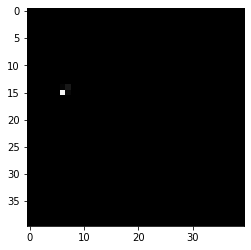

In [8]:
plt.imshow(x_train[-2])


## model.summary()

# read fdss data

In [9]:
#### Removed due to possible syncing/noise issue
# n_test = 24
# date = '11_15_2020'
# test_str = 'test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + "/" + test_str + "/fcss_processed_leo_" + test_str + "_" + date + ".txt"
# tmpdata = pd.read_csv(data_dir)

In [10]:
# tmpdata.head()

# Read Output Data


In [11]:
def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data


In [12]:
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# # data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# qtm_file_data_dir = data_dir + '/qtm_processed_leo_test' + str(n_test) + '_' + date + '.txt'
# #show_qtm_plot = True

# y_gt = read_output_data(qtm_file_data_dir,theta_interest).values
# theta_x = read_output_data(qtm_file_data_dir,'x').values
# theta_y = read_output_data(qtm_file_data_dir,'y').values
# theta_z = read_output_data(qtm_file_data_dir,'z').values

n_test = (24,25)
date = ('11_15_2020','11_19_2020')
y_gt = {}
theta_interest = 'z'
for i in range(len(n_test)):
    test_str = '/test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + test_str
    qtm_file_data_dir = data_dir + '/qtm_processed_leo_test' + str(n_test[i]) + '_' + date[i] + '.txt'
    y_gttemp = read_output_data(qtm_file_data_dir,theta_interest).values
    y_gt[i]=y_gttemp
    
tlen = len(y_gt[0])-2 +len(y_gt[1])-3 #remove 2 samples from 24 and 3 from 25
y_train = np.zeros((tlen,1))
y_train[:len(y_gt[0])-2] = y_gt[0][:len(y_gt[0])-2]
y_train[(len(y_gt[0])-2):] = y_gt[1][:len(y_gt[1])-3]

In [13]:
y_gt[0].shape

(12751, 1)

In [14]:
# Obtain X and Y data
# x_train.shape
# xtrainnew = pd.DataFrame(data=np.reshape(x_train, (x_train.shape[0],x_train.shape[1]*x_train.shape[2])))
# yframe = pd.DataFrame(data=y_train)

# TheData = pd.concat([xtrainnew,yframe],axis=1) #only contains video data
print(x_train.shape)
print(y_train.shape)

(27415, 40, 40, 3)
(27415, 1)


In [15]:
print(xtemp[0].shape)
print(y_gt[0].shape)
print(xtemp[1].shape)
print(y_gt[1].shape)

(12751, 40, 40, 3)
(12751, 1)
(14668, 40, 40, 3)
(14669, 1)


In [16]:
# xtmp = xtrainnew[300,:]
# plt.imshow(np.reshape(xtmp, (x_train.shape[1],x_train.shape[2])))

In [17]:
nsamps = x_train.shape[0]
n80p = int(np.floor(nsamps*0.8))
rannums = np.array(random.sample(range(1,nsamps,1), n80p))
s_nfiles = np.arange(nsamps)
test_set = np.setdiff1d(s_nfiles,rannums)

#

In [18]:
Trainset = x_train[rannums,:]
Testset = x_train[test_set,:]
# Trainy= y_gt[rannums,:]
# Testy = y_gt[test_set,:]
Trainy= y_train[rannums,:]
Testy = y_train[test_set,:]

In [19]:
sc_y = StandardScaler()

In [20]:
Xtrainz = Trainset
ytrainz = Trainy
X = Xtrainz
y = sc_y.fit_transform(ytrainz)

In [21]:
#make validation data available to model.fit
Xvalid = Testset

y_valid = Testy
y_valid = sc_y.transform(y_valid)


In [22]:
x_train.shape[1]

40

# Regress using Neural Network

In [23]:
np.min(Xvalid) #7min*30fps*60s/min*0.8 ~ 10800

0.0

In [24]:
# Create Neural Netowrk
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(X.shape[1],)))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# #model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# model.add(tf.keras.layers.Dropout(0.5))          
# model.add(tf.keras.layers.Dense(100, activation='linear')) #added extra layer. probably overkill but want good results
# model.add(tf.keras.layers.Dense(1, activation='linear'))
# model.compile(optimizer='adam',
#               loss='mae',
#               metrics=['mse','mae'])
    
# # loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # loss_fn(y_train[:1], predictions).numpy()

from keras.layers import Bidirectional, Conv2D, MaxPooling2D, Input, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Activation, Dropout, Reshape, Permute, Flatten
from keras.models import Model
batch_sz = 32
model_start = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
model_cnn = model_start
# f_pool_size = (5,2,2)
dropout_rate = 0.5
# for i, convCnt in enumerate(f_pool_size):
#     model_cnn = Conv2D(filters=x_train.shape[2], kernel_size=(3, 3))(model_cnn)
#     model_cnn = BatchNormalization()(model_cnn)
#     model_cnn = Activation('relu')(model_cnn)
#     model_cnn = MaxPooling2D(pool_size=(f_pool_size[i], f_pool_size[i]))(model_cnn)
#     model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3))(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = MaxPooling2D(pool_size=(1, 1))(model_cnn)
model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3))(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = MaxPooling2D(pool_size=(2, 2))(model_cnn)
model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3))(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = MaxPooling2D(pool_size=(3, 3))(model_cnn)
model_cnn = Dropout(dropout_rate)(model_cnn)


model_cnn = Flatten()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Dense(128)(model_cnn)
model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

# model_cnn = Dense(200)(model_cnn)
# model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

output = Dense(1)(model_cnn)
output = Activation('linear', name='thetaz_out')(output)
model = Model(inputs=model_start,outputs=output)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse','mae'])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True) #Moving to 1000 patience. 
model.summary()

Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 40, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 38, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 38, 38, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 36, 36, 64)        0   

In [25]:
epochs = int(30000)
batch_size = 256
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True)
history = model.fit(X, y,batch_size=batch_size, epochs = epochs,callbacks = [callback],validation_data = (Xvalid, y_valid),verbose=2)

# model.save('depthforcemodel.h5')
#history.save('depthforcehist.h5')

Train on 21932 samples, validate on 5483 samples
Epoch 1/30000
 - 6s - loss: 0.7092 - mse: 1.0437 - mae: 0.7092 - val_loss: 0.6950 - val_mse: 0.9998 - val_mae: 0.6950
Epoch 2/30000
 - 4s - loss: 0.6705 - mse: 0.9589 - mae: 0.6705 - val_loss: 0.6821 - val_mse: 0.9828 - val_mae: 0.6821
Epoch 3/30000
 - 4s - loss: 0.6643 - mse: 0.9482 - mae: 0.6643 - val_loss: 0.6723 - val_mse: 0.9681 - val_mae: 0.6723
Epoch 4/30000
 - 4s - loss: 0.6610 - mse: 0.9383 - mae: 0.6610 - val_loss: 0.6768 - val_mse: 0.9725 - val_mae: 0.6768
Epoch 5/30000
 - 4s - loss: 0.6558 - mse: 0.9278 - mae: 0.6558 - val_loss: 0.6602 - val_mse: 0.9421 - val_mae: 0.6602
Epoch 6/30000
 - 4s - loss: 0.6515 - mse: 0.9139 - mae: 0.6515 - val_loss: 0.6601 - val_mse: 0.9360 - val_mae: 0.6601
Epoch 7/30000
 - 4s - loss: 0.6458 - mse: 0.8986 - mae: 0.6458 - val_loss: 0.6526 - val_mse: 0.9173 - val_mae: 0.6526
Epoch 8/30000
 - 4s - loss: 0.6417 - mse: 0.8916 - mae: 0.6417 - val_loss: 0.6490 - val_mse: 0.9111 - val_mae: 0.6490
Epoch 9

Epoch 70/30000
 - 4s - loss: 0.4718 - mse: 0.5259 - mae: 0.4718 - val_loss: 0.4723 - val_mse: 0.5425 - val_mae: 0.4723
Epoch 71/30000
 - 4s - loss: 0.4695 - mse: 0.5224 - mae: 0.4695 - val_loss: 0.4713 - val_mse: 0.5408 - val_mae: 0.4713
Epoch 72/30000
 - 4s - loss: 0.4668 - mse: 0.5185 - mae: 0.4668 - val_loss: 0.4730 - val_mse: 0.5467 - val_mae: 0.4730
Epoch 73/30000
 - 4s - loss: 0.4677 - mse: 0.5185 - mae: 0.4677 - val_loss: 0.4723 - val_mse: 0.5443 - val_mae: 0.4723
Epoch 74/30000
 - 4s - loss: 0.4631 - mse: 0.5120 - mae: 0.4631 - val_loss: 0.4682 - val_mse: 0.5397 - val_mae: 0.4682
Epoch 75/30000
 - 4s - loss: 0.4644 - mse: 0.5177 - mae: 0.4644 - val_loss: 0.4676 - val_mse: 0.5375 - val_mae: 0.4676
Epoch 76/30000
 - 4s - loss: 0.4628 - mse: 0.5083 - mae: 0.4628 - val_loss: 0.4708 - val_mse: 0.5411 - val_mae: 0.4708
Epoch 77/30000
 - 4s - loss: 0.4605 - mse: 0.5064 - mae: 0.4605 - val_loss: 0.4700 - val_mse: 0.5379 - val_mae: 0.4700
Epoch 78/30000
 - 4s - loss: 0.4598 - mse: 0.503

Epoch 139/30000
 - 4s - loss: 0.4119 - mse: 0.4200 - mae: 0.4119 - val_loss: 0.4340 - val_mse: 0.4720 - val_mae: 0.4340
Epoch 140/30000
 - 4s - loss: 0.4066 - mse: 0.4112 - mae: 0.4066 - val_loss: 0.4367 - val_mse: 0.4757 - val_mae: 0.4367
Epoch 141/30000
 - 4s - loss: 0.4083 - mse: 0.4117 - mae: 0.4083 - val_loss: 0.4230 - val_mse: 0.4637 - val_mae: 0.4230
Epoch 142/30000
 - 4s - loss: 0.4088 - mse: 0.4124 - mae: 0.4088 - val_loss: 0.4235 - val_mse: 0.4654 - val_mae: 0.4235
Epoch 143/30000
 - 4s - loss: 0.4064 - mse: 0.4093 - mae: 0.4064 - val_loss: 0.4243 - val_mse: 0.4656 - val_mae: 0.4243
Epoch 144/30000
 - 4s - loss: 0.4058 - mse: 0.4070 - mae: 0.4058 - val_loss: 0.4247 - val_mse: 0.4625 - val_mae: 0.4247
Epoch 145/30000
 - 4s - loss: 0.4074 - mse: 0.4119 - mae: 0.4074 - val_loss: 0.4310 - val_mse: 0.4696 - val_mae: 0.4310
Epoch 146/30000
 - 4s - loss: 0.4050 - mse: 0.4061 - mae: 0.4050 - val_loss: 0.4294 - val_mse: 0.4673 - val_mae: 0.4294
Epoch 147/30000
 - 4s - loss: 0.4026 - m

Epoch 208/30000
 - 4s - loss: 0.3774 - mse: 0.3598 - mae: 0.3774 - val_loss: 0.4172 - val_mse: 0.4481 - val_mae: 0.4172
Epoch 209/30000
 - 4s - loss: 0.3796 - mse: 0.3649 - mae: 0.3796 - val_loss: 0.4147 - val_mse: 0.4460 - val_mae: 0.4147
Epoch 210/30000
 - 4s - loss: 0.3795 - mse: 0.3635 - mae: 0.3795 - val_loss: 0.4152 - val_mse: 0.4512 - val_mae: 0.4152
Epoch 211/30000
 - 4s - loss: 0.3800 - mse: 0.3645 - mae: 0.3800 - val_loss: 0.4226 - val_mse: 0.4500 - val_mae: 0.4226
Epoch 212/30000
 - 4s - loss: 0.3803 - mse: 0.3632 - mae: 0.3803 - val_loss: 0.4171 - val_mse: 0.4480 - val_mae: 0.4171
Epoch 213/30000
 - 4s - loss: 0.3826 - mse: 0.3683 - mae: 0.3826 - val_loss: 0.4105 - val_mse: 0.4420 - val_mae: 0.4105
Epoch 214/30000
 - 4s - loss: 0.3805 - mse: 0.3641 - mae: 0.3805 - val_loss: 0.4145 - val_mse: 0.4486 - val_mae: 0.4145
Epoch 215/30000
 - 4s - loss: 0.3771 - mse: 0.3575 - mae: 0.3771 - val_loss: 0.4211 - val_mse: 0.4505 - val_mae: 0.4211
Epoch 216/30000
 - 4s - loss: 0.3781 - m

Epoch 277/30000
 - 4s - loss: 0.3619 - mse: 0.3348 - mae: 0.3619 - val_loss: 0.4062 - val_mse: 0.4373 - val_mae: 0.4062
Epoch 278/30000
 - 4s - loss: 0.3637 - mse: 0.3344 - mae: 0.3637 - val_loss: 0.4050 - val_mse: 0.4297 - val_mae: 0.4050
Epoch 279/30000
 - 4s - loss: 0.3634 - mse: 0.3346 - mae: 0.3634 - val_loss: 0.4071 - val_mse: 0.4333 - val_mae: 0.4071
Epoch 280/30000
 - 4s - loss: 0.3607 - mse: 0.3322 - mae: 0.3607 - val_loss: 0.4072 - val_mse: 0.4333 - val_mae: 0.4072
Epoch 281/30000
 - 4s - loss: 0.3608 - mse: 0.3323 - mae: 0.3608 - val_loss: 0.4094 - val_mse: 0.4386 - val_mae: 0.4094
Epoch 282/30000
 - 4s - loss: 0.3679 - mse: 0.3437 - mae: 0.3679 - val_loss: 0.4092 - val_mse: 0.4357 - val_mae: 0.4092
Epoch 283/30000
 - 4s - loss: 0.3626 - mse: 0.3329 - mae: 0.3626 - val_loss: 0.4007 - val_mse: 0.4280 - val_mae: 0.4007
Epoch 284/30000
 - 4s - loss: 0.3610 - mse: 0.3328 - mae: 0.3610 - val_loss: 0.4087 - val_mse: 0.4435 - val_mae: 0.4087
Epoch 285/30000
 - 4s - loss: 0.3605 - m

Epoch 346/30000
 - 4s - loss: 0.3526 - mse: 0.3182 - mae: 0.3526 - val_loss: 0.3976 - val_mse: 0.4232 - val_mae: 0.3976
Epoch 347/30000
 - 4s - loss: 0.3501 - mse: 0.3166 - mae: 0.3501 - val_loss: 0.4012 - val_mse: 0.4267 - val_mae: 0.4012
Epoch 348/30000
 - 4s - loss: 0.3511 - mse: 0.3154 - mae: 0.3511 - val_loss: 0.3953 - val_mse: 0.4163 - val_mae: 0.3953
Epoch 349/30000
 - 4s - loss: 0.3504 - mse: 0.3175 - mae: 0.3504 - val_loss: 0.4068 - val_mse: 0.4339 - val_mae: 0.4068
Epoch 350/30000
 - 4s - loss: 0.3514 - mse: 0.3175 - mae: 0.3514 - val_loss: 0.3994 - val_mse: 0.4213 - val_mae: 0.3994
Epoch 351/30000
 - 4s - loss: 0.3522 - mse: 0.3156 - mae: 0.3522 - val_loss: 0.4034 - val_mse: 0.4301 - val_mae: 0.4034
Epoch 352/30000
 - 4s - loss: 0.3500 - mse: 0.3144 - mae: 0.3500 - val_loss: 0.3998 - val_mse: 0.4248 - val_mae: 0.3998
Epoch 353/30000
 - 4s - loss: 0.3524 - mse: 0.3185 - mae: 0.3524 - val_loss: 0.4006 - val_mse: 0.4286 - val_mae: 0.4006
Epoch 354/30000
 - 4s - loss: 0.3488 - m

Epoch 415/30000
 - 4s - loss: 0.3448 - mse: 0.3091 - mae: 0.3448 - val_loss: 0.3991 - val_mse: 0.4226 - val_mae: 0.3991
Epoch 416/30000
 - 4s - loss: 0.3427 - mse: 0.3001 - mae: 0.3427 - val_loss: 0.3945 - val_mse: 0.4150 - val_mae: 0.3945
Epoch 417/30000
 - 4s - loss: 0.3422 - mse: 0.3040 - mae: 0.3422 - val_loss: 0.3951 - val_mse: 0.4160 - val_mae: 0.3951
Epoch 418/30000
 - 4s - loss: 0.3425 - mse: 0.3025 - mae: 0.3425 - val_loss: 0.3958 - val_mse: 0.4161 - val_mae: 0.3958
Epoch 419/30000
 - 4s - loss: 0.3406 - mse: 0.2991 - mae: 0.3406 - val_loss: 0.3973 - val_mse: 0.4189 - val_mae: 0.3973
Epoch 420/30000
 - 4s - loss: 0.3432 - mse: 0.3024 - mae: 0.3432 - val_loss: 0.3980 - val_mse: 0.4212 - val_mae: 0.3980
Epoch 421/30000
 - 4s - loss: 0.3407 - mse: 0.2989 - mae: 0.3407 - val_loss: 0.3978 - val_mse: 0.4182 - val_mae: 0.3978
Epoch 422/30000
 - 4s - loss: 0.3442 - mse: 0.3063 - mae: 0.3442 - val_loss: 0.3972 - val_mse: 0.4200 - val_mae: 0.3972
Epoch 423/30000
 - 4s - loss: 0.3445 - m

Epoch 484/30000
 - 4s - loss: 0.3346 - mse: 0.2885 - mae: 0.3346 - val_loss: 0.3916 - val_mse: 0.4123 - val_mae: 0.3916
Epoch 485/30000
 - 4s - loss: 0.3391 - mse: 0.2947 - mae: 0.3391 - val_loss: 0.3898 - val_mse: 0.4100 - val_mae: 0.3898
Epoch 486/30000
 - 4s - loss: 0.3390 - mse: 0.2969 - mae: 0.3390 - val_loss: 0.3908 - val_mse: 0.4072 - val_mae: 0.3908
Epoch 487/30000
 - 4s - loss: 0.3359 - mse: 0.2912 - mae: 0.3359 - val_loss: 0.4025 - val_mse: 0.4263 - val_mae: 0.4025
Epoch 488/30000
 - 4s - loss: 0.3363 - mse: 0.2943 - mae: 0.3363 - val_loss: 0.3918 - val_mse: 0.4102 - val_mae: 0.3918
Epoch 489/30000
 - 4s - loss: 0.3354 - mse: 0.2901 - mae: 0.3354 - val_loss: 0.3896 - val_mse: 0.4098 - val_mae: 0.3896
Epoch 490/30000
 - 4s - loss: 0.3351 - mse: 0.2905 - mae: 0.3351 - val_loss: 0.3906 - val_mse: 0.4110 - val_mae: 0.3906
Epoch 491/30000
 - 4s - loss: 0.3362 - mse: 0.2905 - mae: 0.3362 - val_loss: 0.3905 - val_mse: 0.4090 - val_mae: 0.3905
Epoch 492/30000
 - 4s - loss: 0.3363 - m

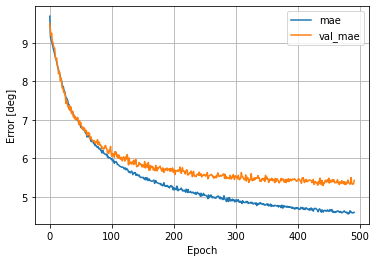

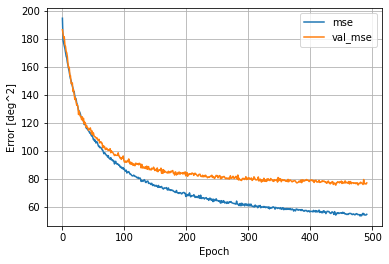

In [26]:
def plot_loss(history):
    
    v1 = history.history['mae']*np.sqrt(sc_y.var_)
    v2 = history.history['val_mae']*np.sqrt(sc_y.var_)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.plot(v1, label='mae')
    ax1.plot(v2, label='val_mae')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Error [deg]')
    ax1.legend()
    ax1.grid(True)
    plt.show()
    
    v3 = history.history['mse']*sc_y.var_
    v4 = history.history['val_mse']*sc_y.var_
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(v3, label='mse')
    ax2.plot(v4, label='val_mse')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Error [deg^2]')
    ax2.legend()
    ax2.grid(True)
    plt.show()
    
    
plot_loss(history)


### 4-layer Network: Predict Against Training Data as a Sanity Check

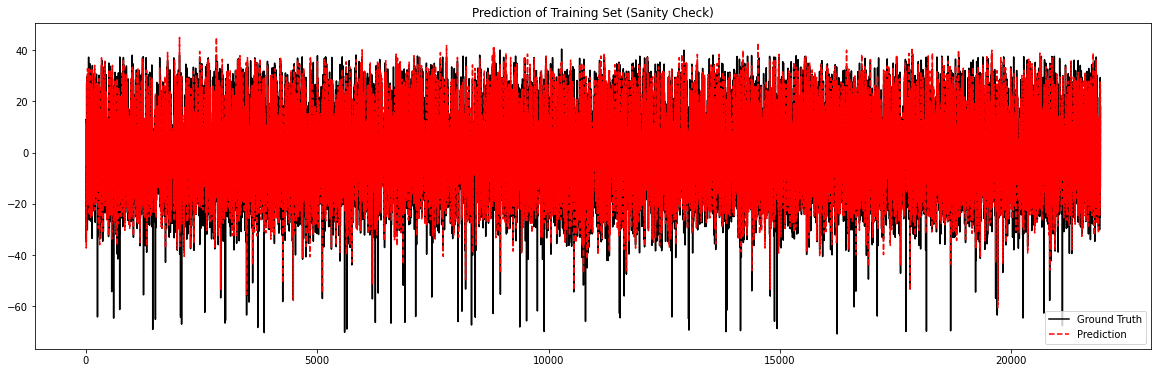

Average error is 0.10 degrees
Root Mean Squared Error is 3.11 degrees
Mean Absolute Error is 3.11 degrees


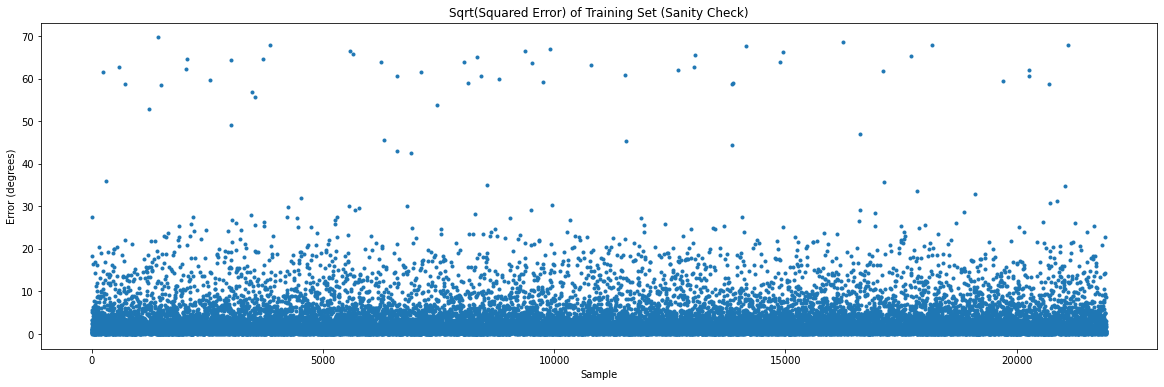

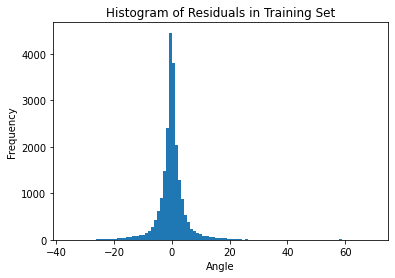

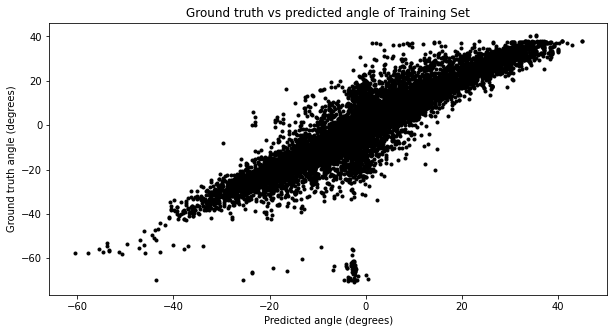

In [27]:

# sanity check with 80% data
Xtrain = Trainset
y_pred = model.predict(Xtrain)
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Trainy
plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Training Set (Sanity Check)')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()
# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Training Set (Sanity Check)')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Training Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle of Training Set')
plt.show()

### 4-layer Neural Network: Predict Test Set

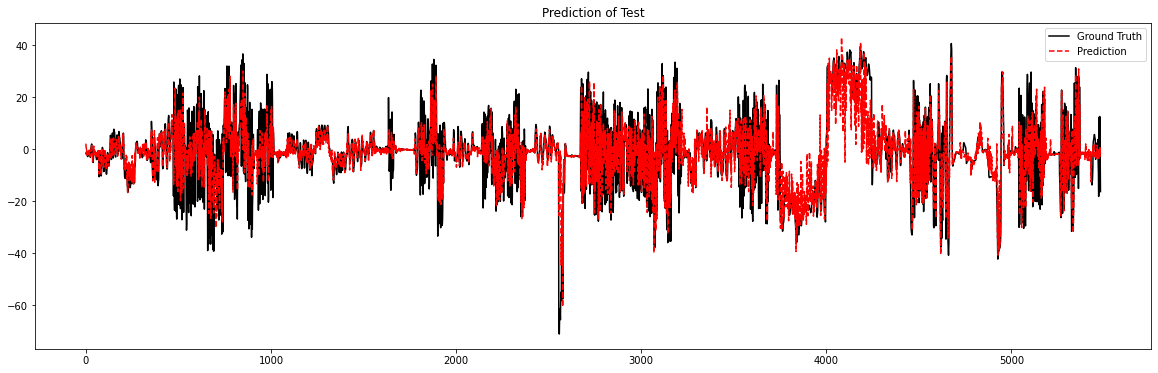

Average error is 0.15 degrees
Root Mean Squared Error is 5.29 degrees
Mean Absolute Error is 5.29 degrees


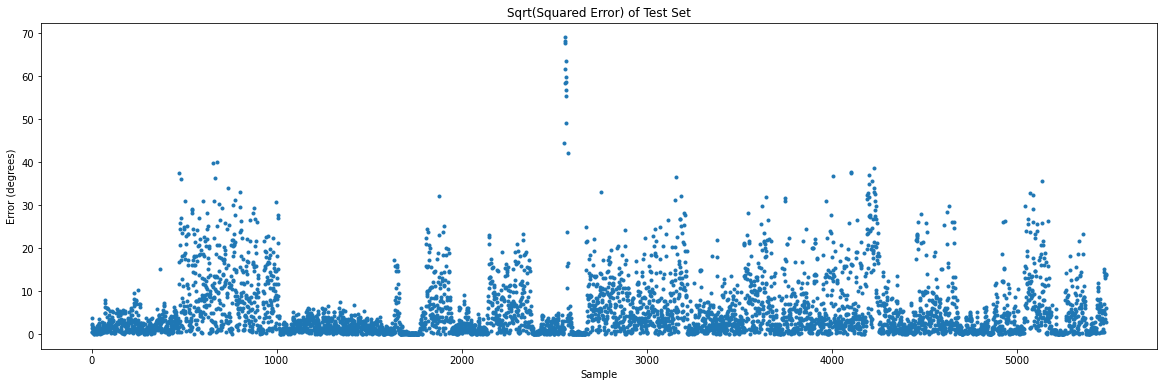

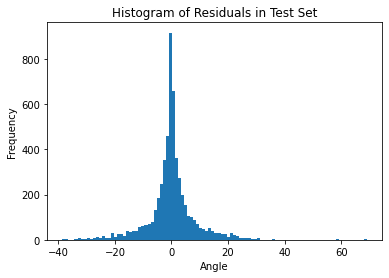

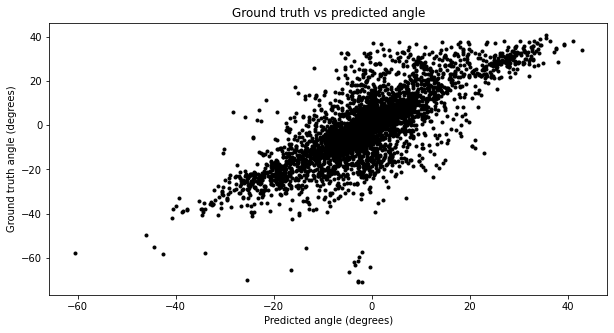

In [28]:
# Redo test set
Xtest = Testset
y_pred = model.predict(Xtest)
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Testy

plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()

# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Test Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Test Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle')
plt.show()

In [561]:
save_notebookparams = 1
if save_notebookparams:
    pkl_filename = "depthforcemodelparam_cnn3v6.pkl"
    randata = {}
    randata['nsamps']=nsamps
    randata['n80p']=n80p
    randata['rannums']=rannums
    randata['test_set']=test_set
    modelhistory = history.history
    
    
    with open(pkl_filename, 'wb') as file:
        pickle.dump([randata,sc_y,modelhistory], file)
        
    model.save('depthforcemodel_cnn3v6.h5') 